# Configuration

## Dependencies

In [97]:
# import necessary packages
import sys
sys.path.append('..')
import os
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import neuropythy as ny
import matplotlib as mpl
import itertools
import warnings
from itertools import product
from visualization import plot_contours as viscontours
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
#mpl.rcParams['figure.dpi'] = 72*2
#mpl.rcParams['savefig.dpi'] = 72*4

## Paths

In [109]:
from pathlib import Path
cache_path       = Path('/data/crcns2021/hcpannot-cache')
image_cache_path = cache_path / 'annot-images'
v123_cache_path  = cache_path / 'annot-v123'
csulc_cache_path = cache_path / 'annot-csulc'
# The save path of the data branch:
data_path = Path('/data/crcns2021/results/data_branch/save')
# The processing path and subpaths:
proc_path    = Path('/data/crcns2021/results/proc')
traces_path  = proc_path / 'traces'
paths_path   = proc_path / 'paths'
means_path   = proc_path / 'means'
labels_path  = proc_path / 'labels'
reports_path = proc_path / 'reports'

# The file of visual surface areas for the ventral data.
ventral_sarea_path = proc_path / 'ventral_sareas.tsv'

# The hcpannot library path; if hcpannot is not on the path for
# this notebook, the notebook will try to figure out where it is
# and will use this directory as a backup.
hcpannot_lib_path = Path('~/code/hcp-annot-vc_analysis')

# If you aren't using /data
os.environ['HCPANNOT_LOAD_PATH'] = os.fspath(cache_path)

In [110]:
# Make sure we can find the hcpannot library. If we were given a path for the
# hcpannot library, we add it to the system path here.
if hcpannot_lib_path:
    hlp = os.path.expandvars(os.fspath(hcpannot_lib_path))
    hlp = os.path.expanduser(hlp)
    if hlp.strip('/').endswith('hcpannot'):
        warnings.warn(
            "adding hcpannot_lib_path that ends with 'hcpannot';"
            " the hcpannot_lib_path should contain the hcpannot directory")
    if os.path.isdir(hlp):
        sys.path.append(hlp)
    else:
        raise ValueError("hcpannot_lib_path is not a directory")
# We try importing it and if we fail, we check to see if we are just running
# the notebook from the work directory and try again.
try:
    import hcpannot
except ModuleNotFoundError:
    hcpannot = None
    if os.getcwd().endswith('/work'):
        hlp = os.path.abspath('..')
        sys.path.append(hlp)
        
# Now we can import the hcp-annot-vc library. (It may have been imported
# above in the try block, but that's fine!)
import hcpannot

# Note the cache path we want to use outside the docker container;
# normally this gets set by the Docker startup, so here outside
# the docker container we set it manually.
hcpannot.interface.default_load_path = str(cache_path)
# We have to update some data after setting this.

# Subject lists. These are defined in the analysis subpackage of
# the hcpannot library, and subject_list_<x> is the <x>th list of
# subject IDs that we assigned.
from hcpannot.config import (
    subject_list,
    subject_list_1,
    subject_list_2,
    subject_list_3)
# The subject IDs we are processing over, as a numpy array.
sids = np.array(subject_list)

# The mean rater's name ('mean') and some plotting functions are also defined in
# the hcpannot.analysis subpackage.
from hcpannot.analysis import plot_contours

# Finally, the proc and meanproc functions, which give us the processed data.
from hcpannot.proc import proc, meanproc

In [111]:
def load_report(region, rater, sid, h):
    """Loads surface area report for the region, rater, sid, and hemisphere.
    
    The region should be the name of one of the contour regions, e.g.
    `'ventral'`. Loads a dictionary of the processing report for the given
    rater, subject, and hemisphere, and returns a processed version of that
    report. The processing includes both square-mm and percentage reports of the
    surface area.
    
    If the file for the report is not found, it is skipped and the values are
    left as NaN.
    """
    from json import load
    data = {
        'rater':rater,
        'sid':sid,
        'hemisphere':h}
    for k in region_areas[region]:
        data[f'{k}_mm2'] = np.nan
        data[f'{k}_percent'] = np.nan
    try:
        path = os.path.join(reports_path, rater, str(sid))
        flnm = os.path.join(path, f'{h}.{region}_sareas.json')
        with open(flnm, 'rt') as fl:
            sarea = load(fl)
        for (k,v) in sarea.items():
            data[f'{k}_mm2'] = v
            if k != 'cortex':
                data[f'{k}_percent'] = v * 100 / sarea['cortex']
    except Exception as e:
        pass
    return data
def load_allreports(region, include_mean=True, sids=subject_list):
    """Loads all reports for a region and returns a dataframe of them.
    
    This runs `load_report` over all raters, subjects, and hemispheres and
    returns a dataframe of all the reports. If a report file is not found,
    then the row is left with NaNs indicating missing data.
    """
    if include_mean:
        if include_mean == True:
            include_mean = 'mean'
        include_mean = [include_mean]
    else:
        include_mean = []
    raters = (region_raters[region] + include_mean)
    return pd.DataFrame(
        [load_report(region, rater, sid, h)
         for rater in raters
         for sid in sids
         for h in ('lh', 'rh')])
def nestget(d, k):
    """Retrieves nested data from the proc dictionaries.
    
    Certain keys such as `'boundaries'` are accessible in the dictionaries that
    are returned by the `proc` function only via the `'nested_data'` key, which
    typically contains another proc dictionary with additional data. The
    `nestget` function gets data from these embedded dictionaries.
    """
    while k not in d:
        d = d['nested_data']
    return d[k]

## Annot-metadata
 * contours, trace: the raw lines (VO1_VO2) saved in .json file that we drew
 * path: processed contours

In [112]:
# The sets of raters we use.
ventral_raters = [
    'BrendaQiu',
    'bogengsong',
    'JiyeongHa',
    'lindazelinzhao',
    'nourahboujaber',
    'jennifertepan']
region_raters = {
    'ventral': ventral_raters}

# The visual areas included in each pipeline/region.
region_areas = {
    'early': ('V1', 'V2', 'V3'),
    'ventral': ('hV4', 'VO1', 'VO2'),
    'dorsal': ('V3a', 'V3b', 'IPS0', 'LO1')}

roi_list = []
#roi_list += [k for k in region_areas['early']]
roi_list += [k for k in region_areas['ventral']]

# The hemispheres we are processing over.
hemis = ['lh', 'rh']

contour_list = ['hV4', 'hV4_VO1', 'VO1_VO2', 'VO_outer']


# Get raw contour .json files

In [113]:
contours_df = pd.DataFrame({})
for hemi, contour, researcher in itertools.product(hemis, contour_list, ventral_raters):
    tmp_df = pd.DataFrame({})
    trace_path_list = viscontours.get_contour_list_drawn_by_rater(data_path,
                                                                  hemi,
                                                                  contour,
                                                                  researcher,
                                                                  return_full_path=True)
    tmp_df['sid'] = [int(k.split('/')[-2]) for k in trace_path_list]
    tmp_df['researcher'] = researcher
    tmp_df['contour'] = contour
    tmp_df['hemi'] = hemi
    contours_df = pd.concat((contours_df, tmp_df))

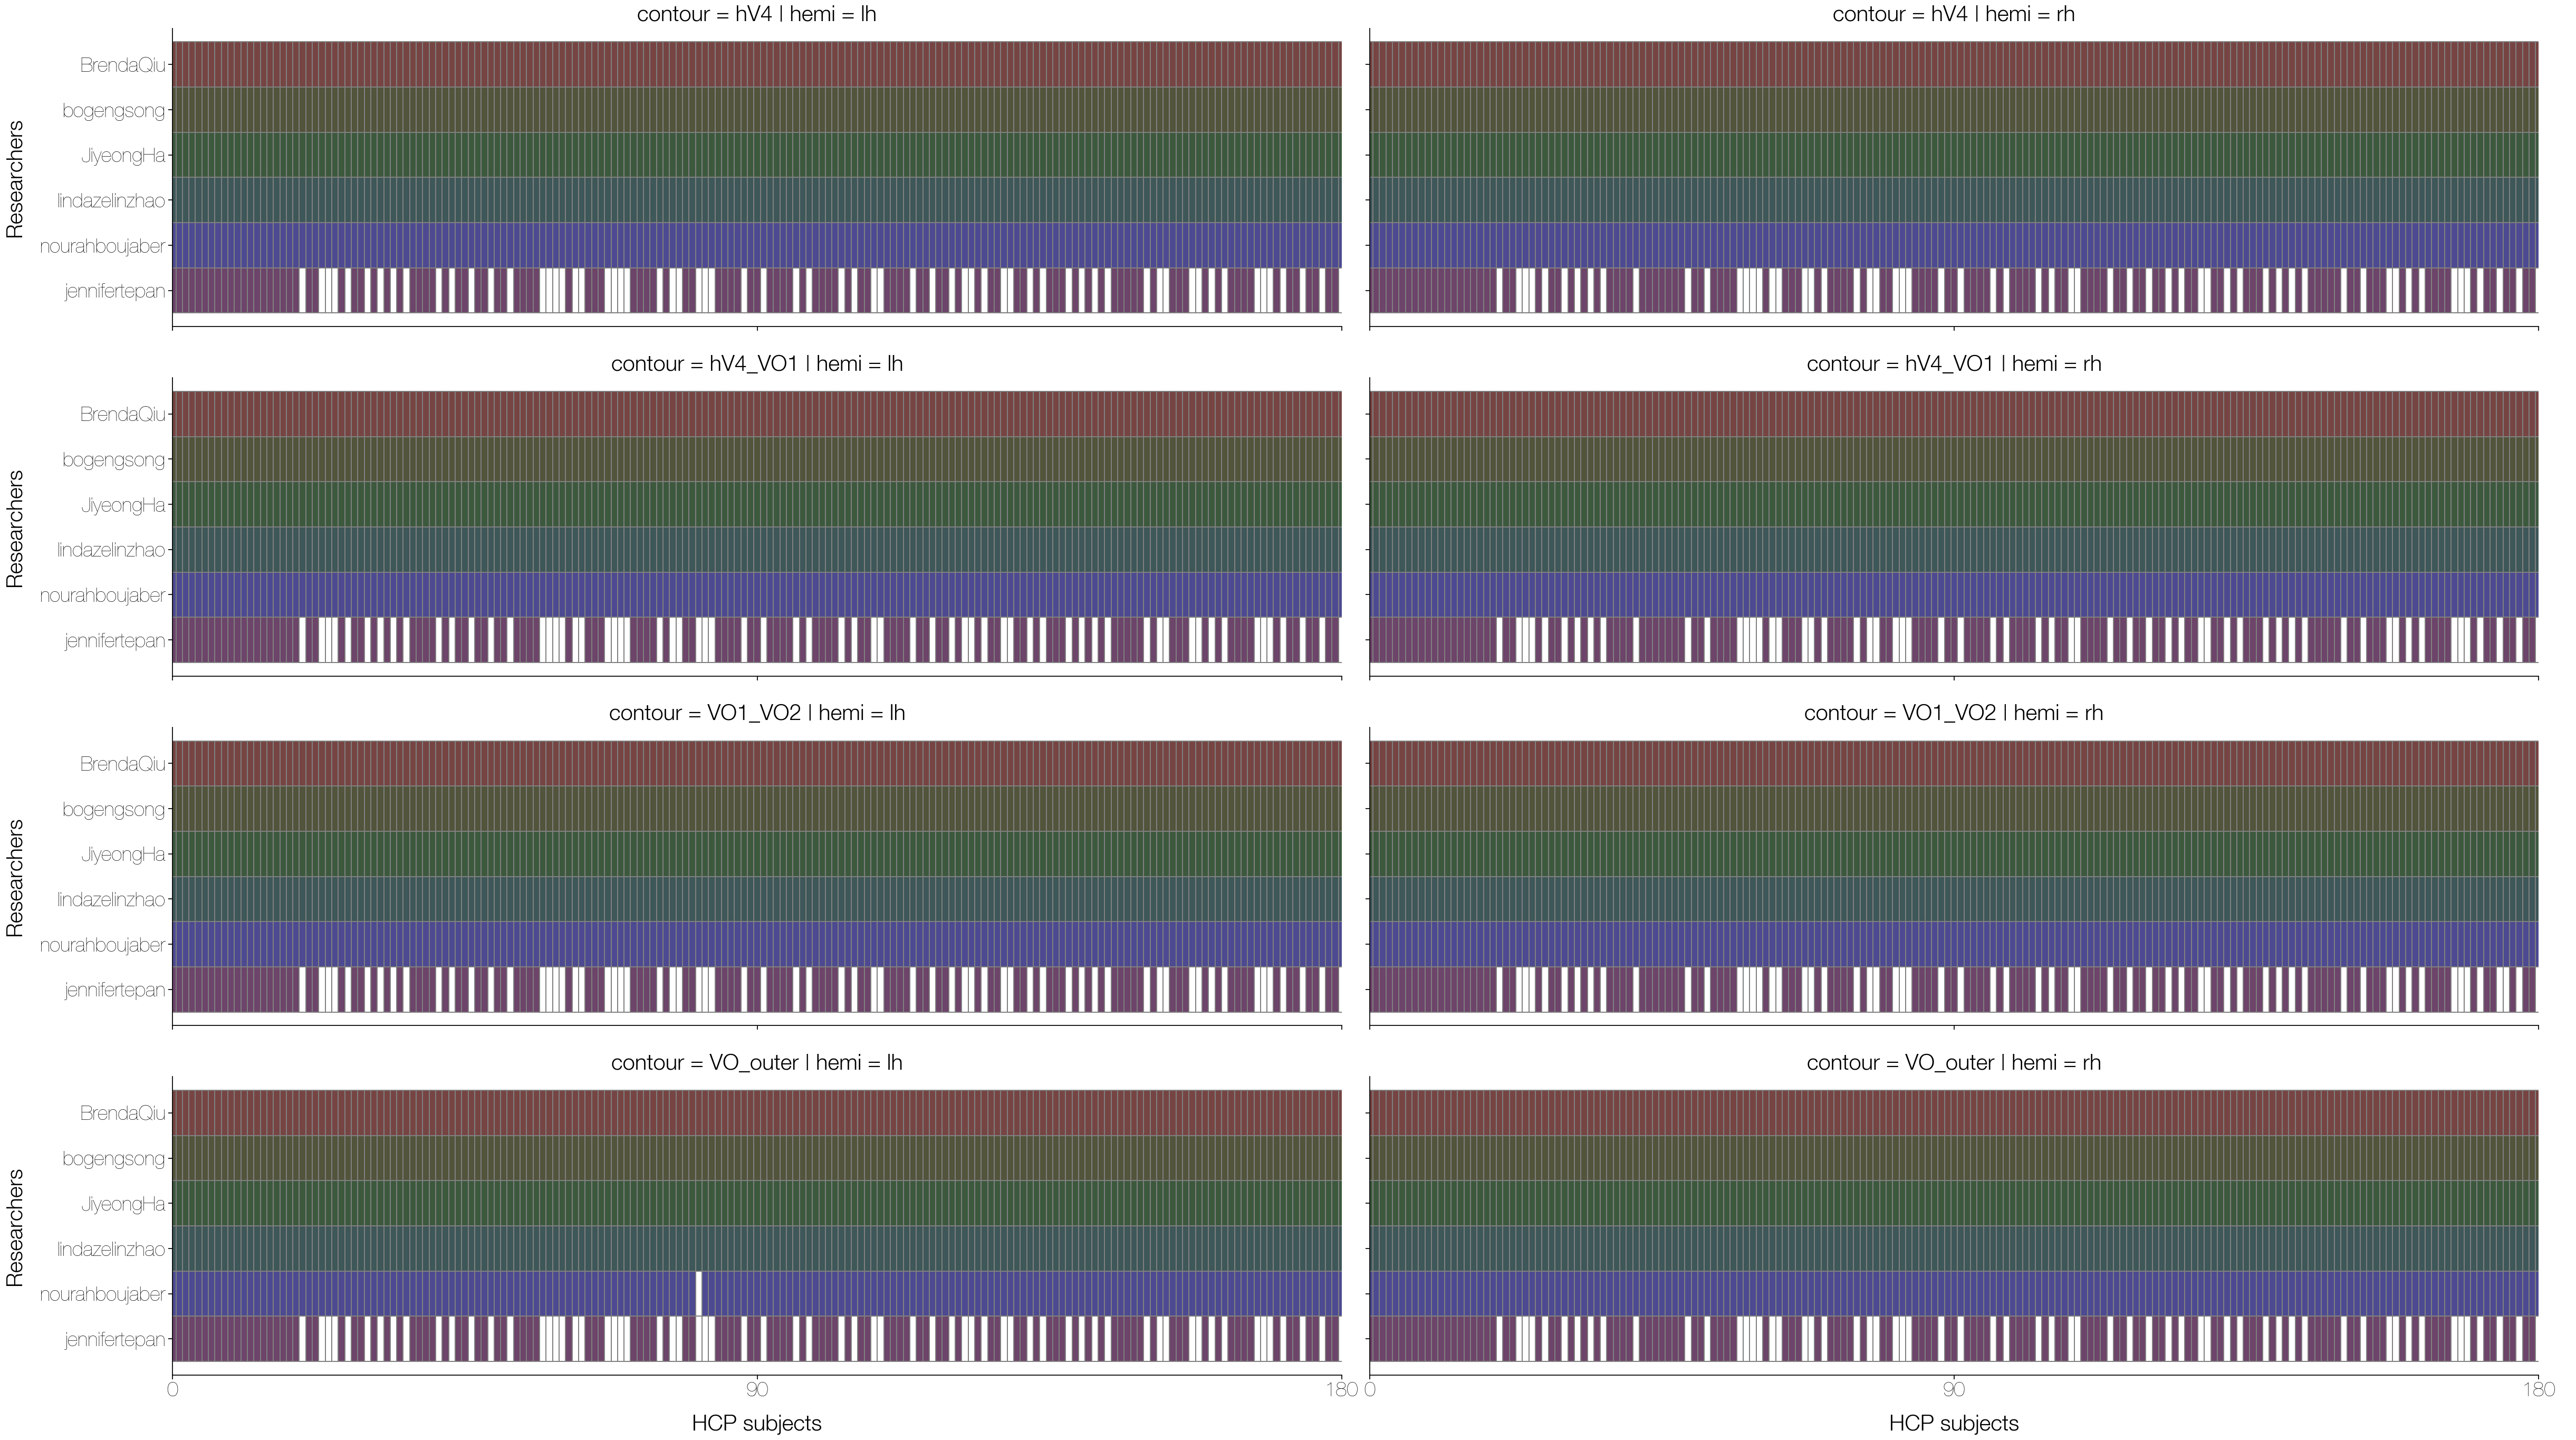

In [114]:
viscontours.check_sids(df=contours_df,
                       sid='sid', y='researcher',
                       col='hemi', col_order=hemis,
                       row='contour', row_order=contour_list,
                       height=7,
                       hue='researcher', hue_order=ventral_raters, save_path=None)

# Make Path

In [51]:
rater = 'mean'
hemi= 'lh'
contour = contour_list[0]
sid='169444'
n_points=500
save_path=os.path.join(proc_path, 
                       'fsaverage', 
                       f"cacherater_{rater}_{sid}_{hemi}_{contour}.mgz")
stream='ventral'

viscontours.make_fsaverage_coords('ventral',
                                  rater,
                                  hemi,
                                  contour,
                                  sid,
                                  n_points,
                                  data_dir,
                                  proc_path,
                                  save_path,
                                  verbose=True,
                                  return_annot=True)

# Get processed trace files

In [139]:
a = os.path.join(proc_path, 'fsaverage', f'cacherater_{rater}_*_{hemi}_{contour}.mgz')
a.split(f'_{hemi}')[0].split('_')[-1]

['/data/crcns2021/results/proc/fsaverage/cacherater', 'mean', '*']

In [140]:
n_points=500
paths_df = pd.DataFrame({})
for hemi, contour, researcher in itertools.product(hemis, contour_list, ventral_raters + ['mean']):
    tmp_df = pd.DataFrame({})
    path_list = glob(os.path.join(proc_path, 'fsaverage', f'cacherater_{rater}_*_{hemi}_{contour}.mgz'))
    tmp_df['sid'] = [k.split(f'_{hemi}')[0].split('_')[-1] for k in path_list]
    tmp_df['researcher'] = researcher
    tmp_df['roi'] = contour
    tmp_df['hemi'] = hemi
    paths_df = pd.concat((paths_df, tmp_df))

In [146]:
paths_df.query('researcher == "jennifertepan" & hemi == "lh" & roi == "hV4"')

,sid,researcher,roi,hemi
0,158136,jennifertepan,hV4,lh
1,115017,jennifertepan,hV4,lh
2,352738,jennifertepan,hV4,lh
3,169040,jennifertepan,hV4,lh
4,146129,jennifertepan,hV4,lh
...,...,...,...,...
176,102816,jennifertepan,hV4,lh
177,320826,jennifertepan,hV4,lh
178,209228,jennifertepan,hV4,lh
179,257845,jennifertepan,hV4,lh


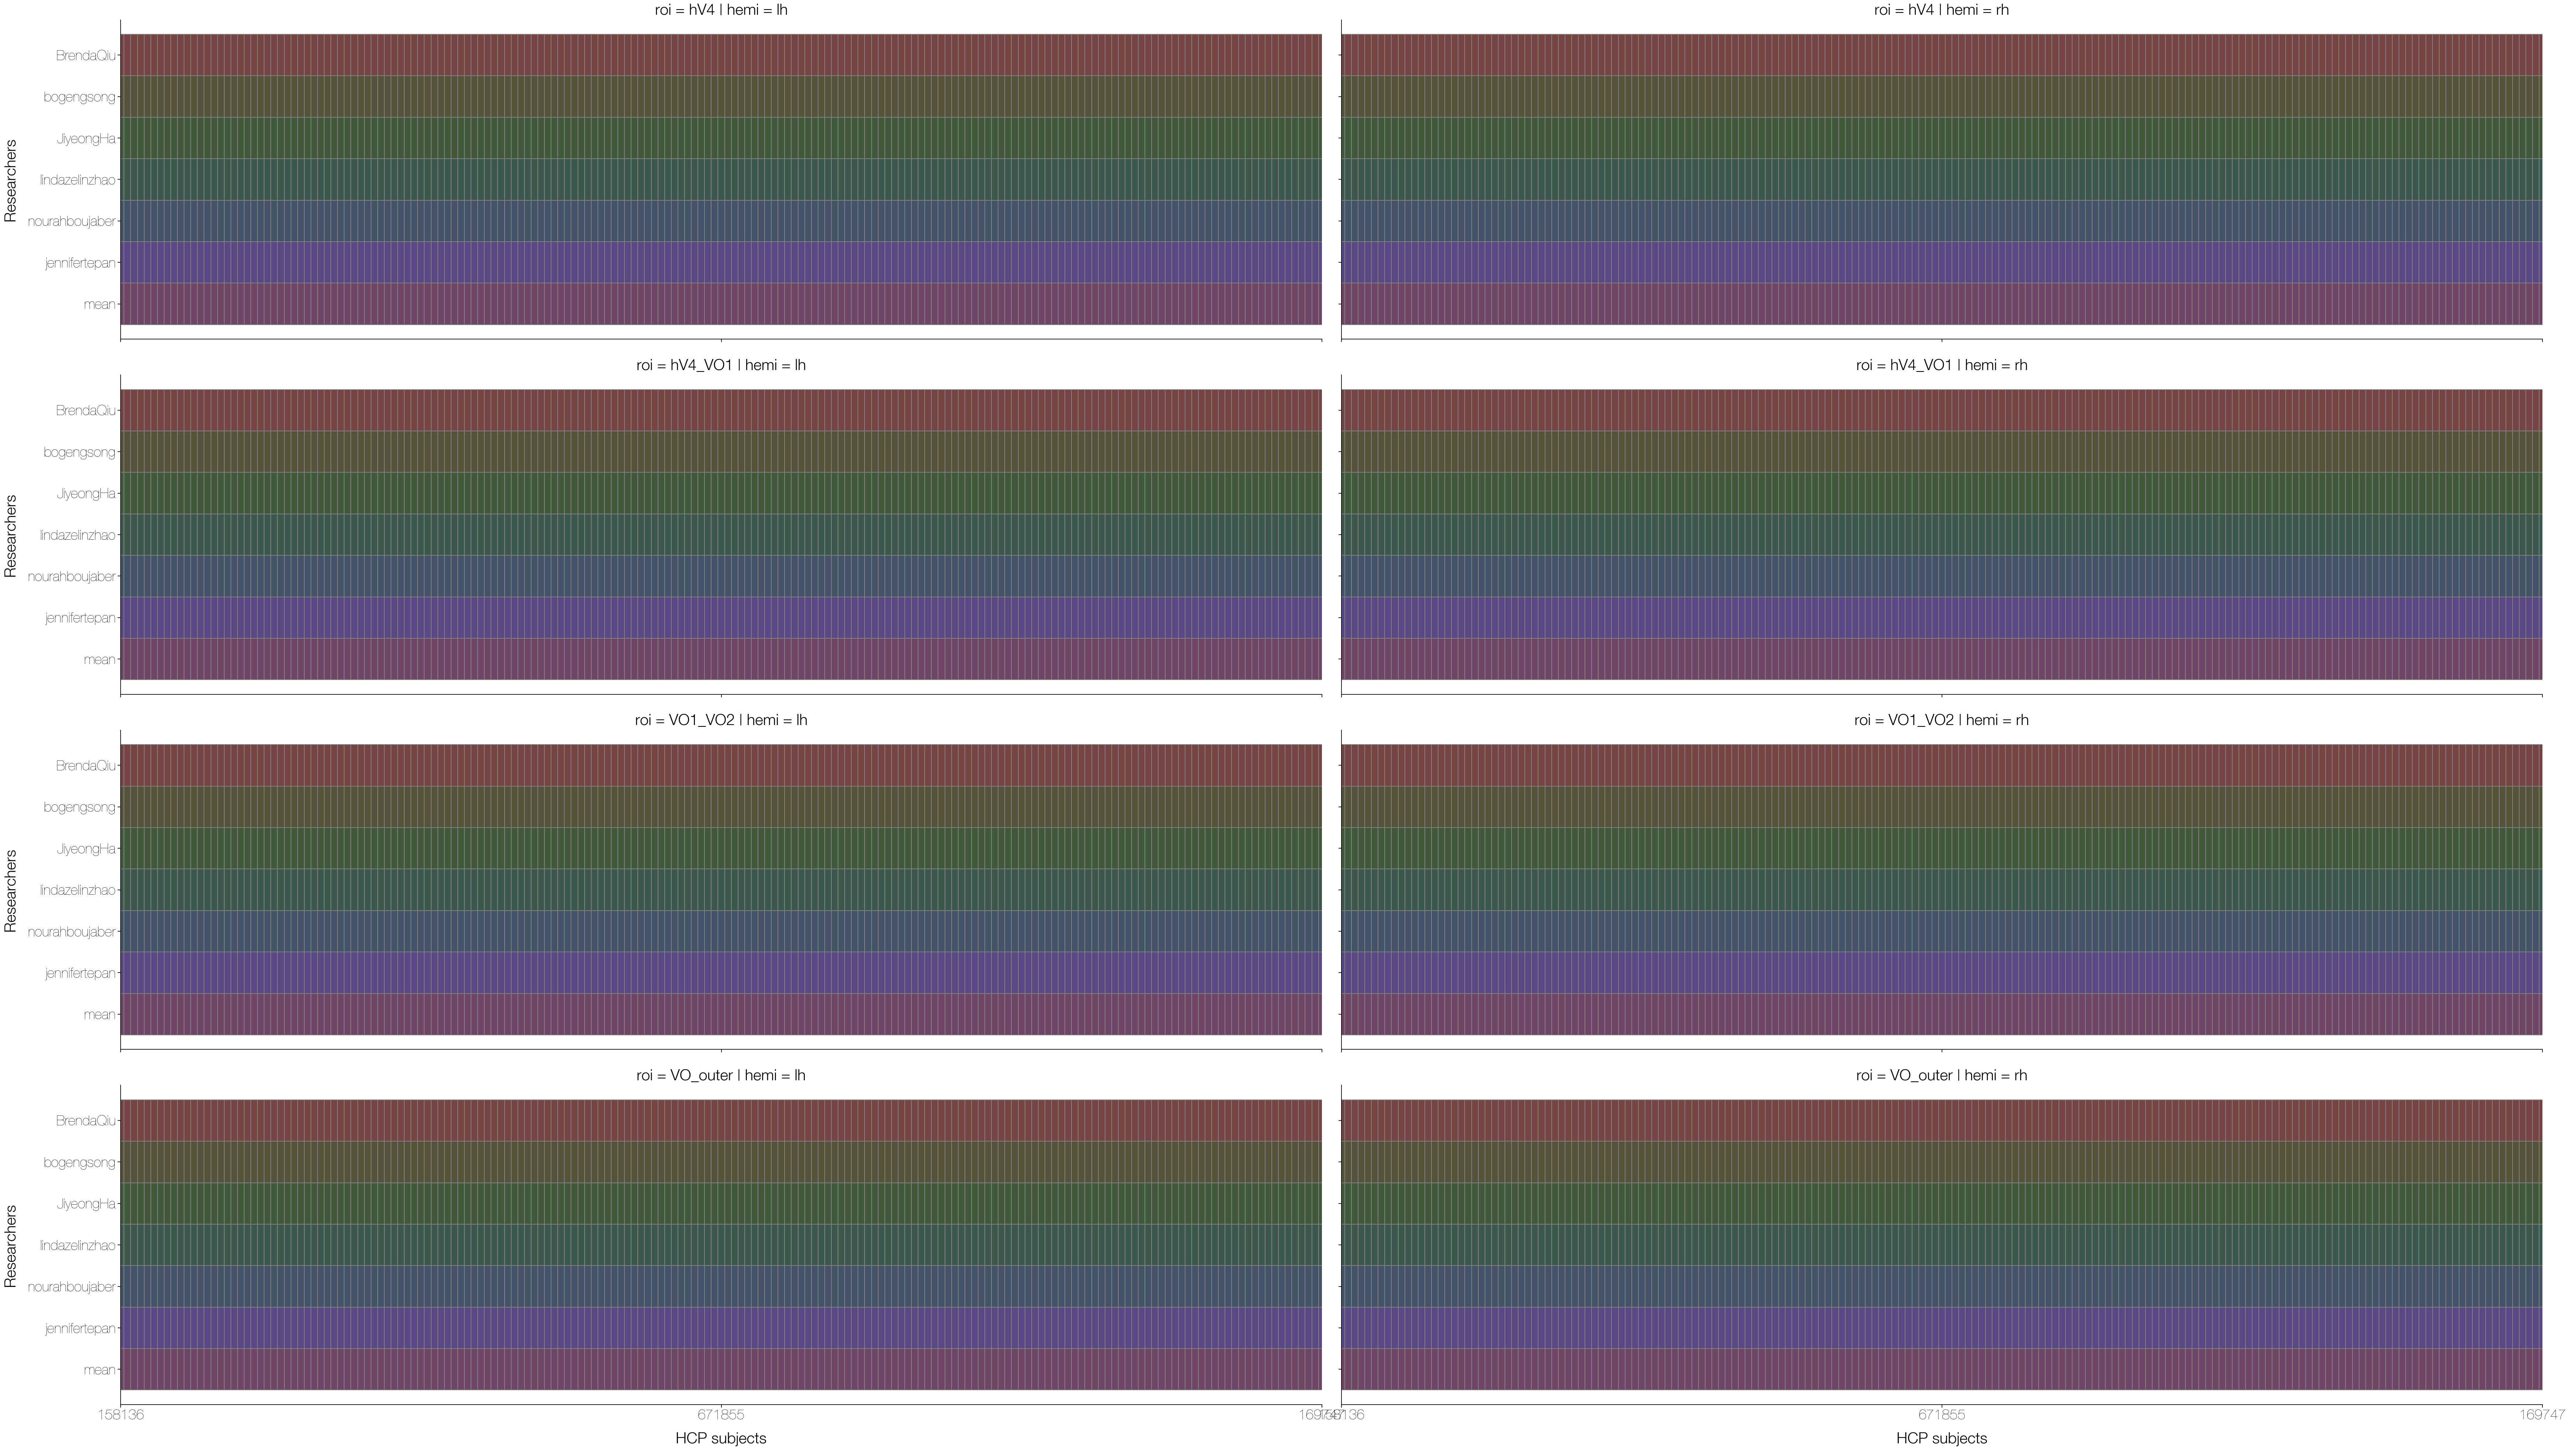

In [142]:
viscontours.check_sids(df=paths_df,
                       sid='sid', y='researcher',
                       col='hemi', col_order=hemis,
                       row='roi', row_order=contour_list,
                       height=10,
                       hue='researcher', hue_order=ventral_raters+['mean'], save_path=None)

# Plot averaged ROIs 